In [35]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

import os
import glob
import ast
import matplotlib

import numpy as np
from scipy.optimize import curve_fit

In [36]:
def sine_function(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [37]:
# measurements folder path
folder_path = "measurements\\measurements_after_HWP_fm2\\"
folder_path = "measurements/measurements_after_HWP_fm2/"

# Get all CSV files in the folder
files_after_hwp = glob.glob(os.path.join(folder_path, "*.csv"))
print(len(files_after_hwp), 'after amount of meas')

43 after amount of meas


In [38]:
# before hwp folder path
folder_path = "analog_data/before_hwp/"
files_before_hwp =  glob.glob(os.path.join(folder_path, "*.csv"))
print(len(files_before_hwp), 'before hwp amount of meas')

34 before hwp amount of meas


In [39]:
#read in darkcounts
darkcounts = pd.read_csv(files_after_hwp[0])
darkcounts_before = pd.read_csv(files_before_hwp[0], skiprows=2)

In [40]:
# save all for all measured rfs the loaded df into a list
all_after = [pd.read_csv(file) for file in files_after_hwp[1:]]
all_before = [pd.read_csv(file, skiprows=2) for file in files_before_hwp[1:]]

In [41]:
#initiate dicts for saving before avgs
before_hwp_dict = {}
before_hwp_avg = {}
after_hwp_dict = {}

In [42]:
def rfsort(n):
    n = n[2:]
    n = int(n)
    return n

In [43]:
for i, data in enumerate(all_after):
    rf = os.path.basename(files_after_hwp[i+1]).split('rf')[1].split('.csv')[0] #str for rf 
    after_hwp_dict[rf] = data

In [44]:
for i, data in enumerate(all_before):
    rf = os.path.basename(files_before_hwp[i+1]).split('rf_')[1][0:3]
    rf = rf.split('.')[0]
    label = f'rf{rf}'
    # print(i, label)
    before_hwp_dict[label] = data
    before_hwp_avg[label] = np.average(before_hwp_dict[label][' Measurement'])


In [45]:
n_lines = len(before_hwp_avg)
cmap = matplotlib.colormaps['plasma']

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))
print(len(colors))

33


In [46]:
# chanigning keys for before hwp so theyre consistent
keys = sorted(before_hwp_avg.keys(), key=rfsort)

print(len(keys), keys)
temp_dict = {}
for key in keys:
    if len(key) == 3:
        newkey = 'rf0' + key.split('rf')[1]
        temp_dict[newkey] = before_hwp_avg[key]
    else:
        temp_dict[key] = before_hwp_avg[key]

before_hwp_avg = temp_dict

33 ['rf01', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6', 'rf7', 'rf8', 'rf9', 'rf15', 'rf20', 'rf25', 'rf30', 'rf35', 'rf40', 'rf45', 'rf50', 'rf55', 'rf60', 'rf65', 'rf70', 'rf75', 'rf78', 'rf80', 'rf83', 'rf85', 'rf88', 'rf90', 'rf92', 'rf94', 'rf96', 'rf98', 'rf100']


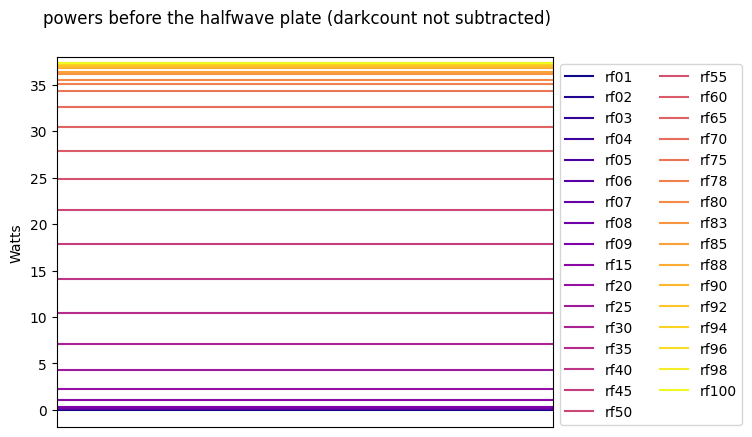

In [47]:
for i, (rf, avg) in enumerate(before_hwp_avg.items()):
    # print(rf, avg)
    plt.axhline(avg, label=rf, color = colors[i])
    plt.legend(ncol= 2, bbox_to_anchor = (1,1))
    plt.ylabel('Watts')
    plt.suptitle('powers before the halfwave plate (darkcount not subtracted)')
    #x ticks off
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off   

Text(0.5, 0.98, 'Power before HWP')

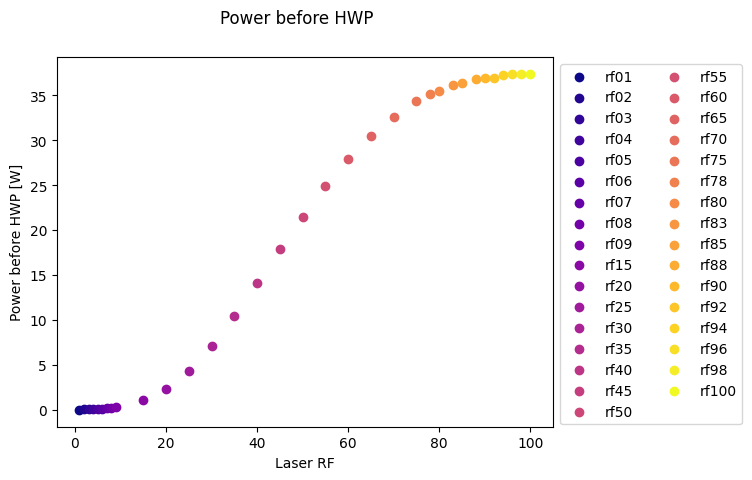

In [48]:
for i, (rf, avg) in enumerate(before_hwp_avg.items()):
    # print(rf, avg)
    # plt.axhline(avg, label=rf, color = colors[i])
    # plt.legend(ncol = 2, bbox_to_anchor = (1,1))
    plt.scatter(int(rf[2:]), avg, color = colors[i], label = rf)
plt.legend(ncol = 2, bbox_to_anchor = (1,1))
plt.xlabel('Laser RF')
plt.ylabel('Power before HWP [W]')
plt.suptitle("Power before HWP")

In [49]:
colors2 = cmap(np.linspace(0, 1, 42))

In [50]:
keys_after = list(after_hwp_dict.keys())
print(keys_after)

['01', '012', '01_02', '02', '02_02', '03', '03_02', '04', '04_02', '04_03', '05_06_N48_blackmeasurement_nosleep', '06', '07', '08', '09', '10', '100', '10_02', '10_right', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '92', '94', '96', '98', 'darkcount_20241022', 'test_cooling2', 'test_poweroff']


In [51]:
# re-saving steps counts

for i, key in enumerate(keys_after):
    after_hwp_dict[key]['rotor_step'] = after_hwp_dict[key].apply(lambda x: x['rotor_step'].split('[')[1].split(',')[0], axis = 1) #OK!
    after_hwp_dict[key]['rotor_step'] = after_hwp_dict[key]['rotor_step'].apply(lambda x: int(x))

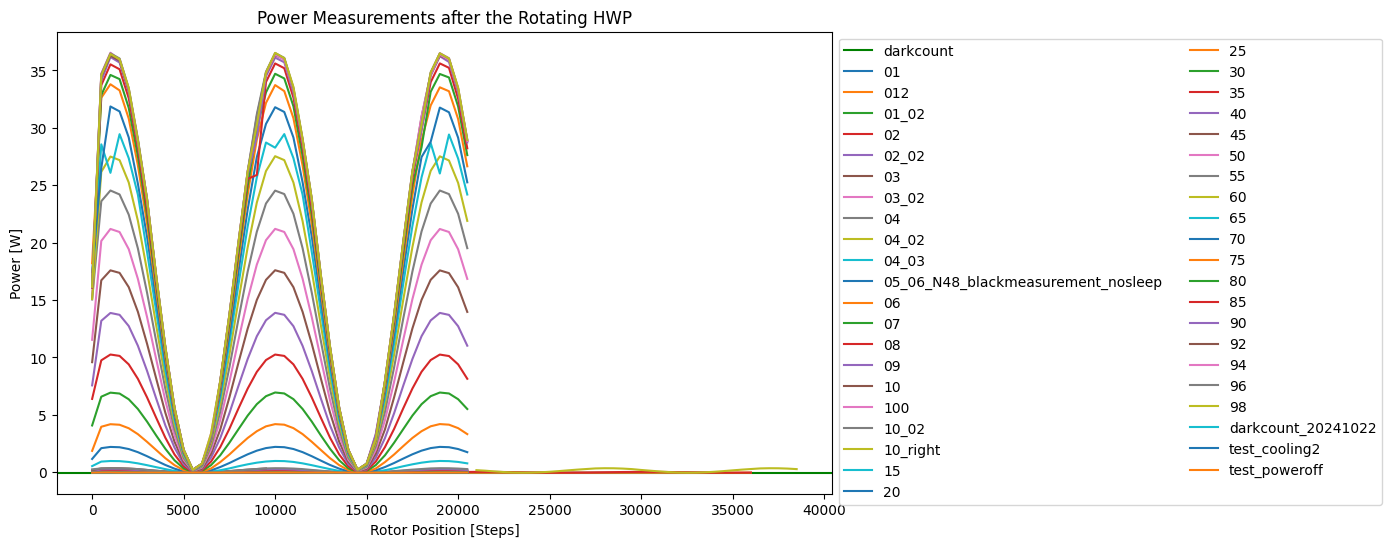

In [52]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')

for i, key in enumerate(keys_after):
    data = after_hwp_dict[key]
    steps = np.array(data['rotor_step'])
    vals = data['averaged']
    # error = np.array(data['stdev'])
    plt.plot(steps, vals, label = key)


plt.legend(ncol =2 ,bbox_to_anchor = (1,1) )

In [53]:
def fitter(x,y, p0_amp, label = None ):
    x = x[1:]
    y = y[1:]
    
    p0 = [p0_amp, 2*np.pi/8000, 0, 0]
    params, covariance = curve_fit(sine_function, x, y, p0=p0)

    # Extract the fitted parameters
    A_fit, B_fit, C_fit, D_fit = params

    print(f"{label} - fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}")
    # Generate y values using the fitted parameters
    steps = np.arange(min(x), max(x), 100)
    y_fit = sine_function(steps, A_fit, B_fit, C_fit, D_fit)

    return params, steps, y_fit

In [54]:
print(keys_after)
after_hwp_select = after_hwp_dict
# after_hwp_select.pop('darkcount_20241022')
# after_hwp_select.pop('test_cooling2')
# after_hwp_select.pop('test_poweroff')

['01', '012', '01_02', '02', '02_02', '03', '03_02', '04', '04_02', '04_03', '05_06_N48_blackmeasurement_nosleep', '06', '07', '08', '09', '10', '100', '10_02', '10_right', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '92', '94', '96', '98', 'darkcount_20241022', 'test_cooling2', 'test_poweroff']


In [55]:
fit_params_results = np.zeros((len(after_hwp_select), 4), dtype=float)

01 - fitted parameters: A=7.518339442120142e-05, B=0.0005933594090776436, C=3.406661751035975, D=-0.03401615918379423


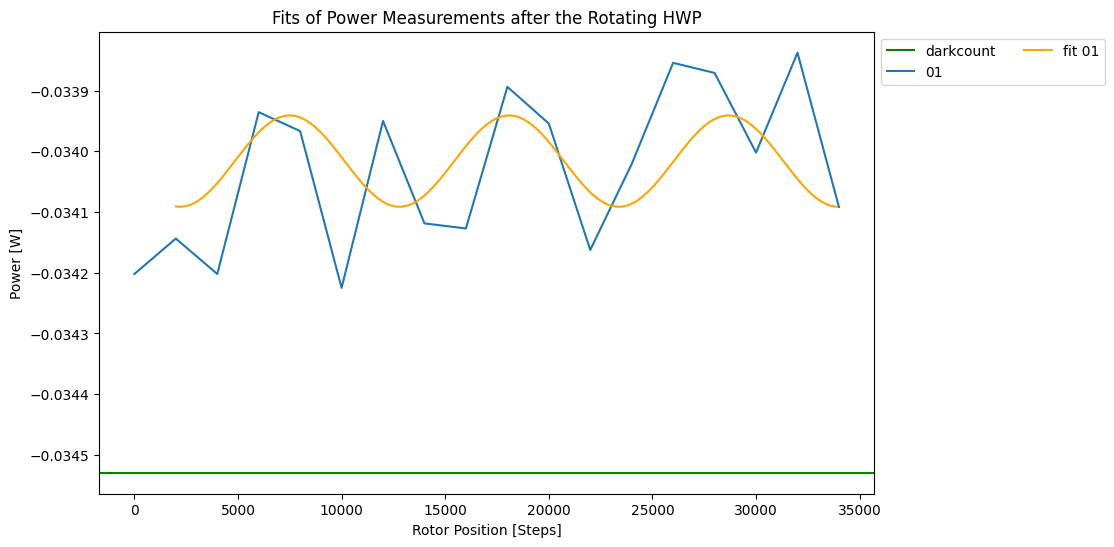

012 - fitted parameters: A=7.083255091244707e-05, B=0.000906392436603307, C=-2.6620456386010667, D=-0.03402110915912535


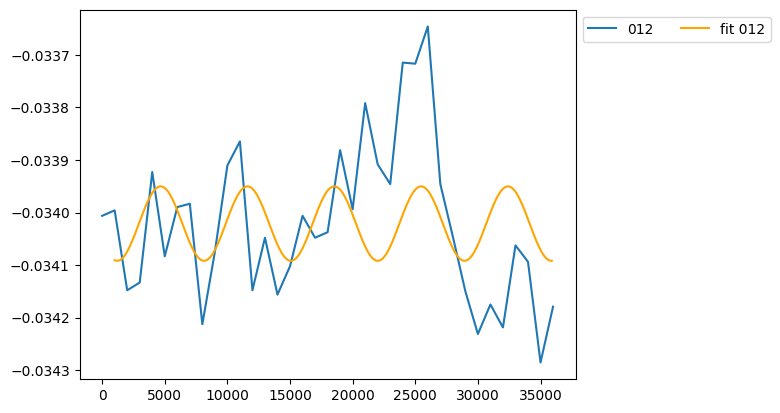

01_02 - fitted parameters: A=0.0003564522127554012, B=0.0006825429980004016, C=0.48632567186060066, D=-0.032064858102999236


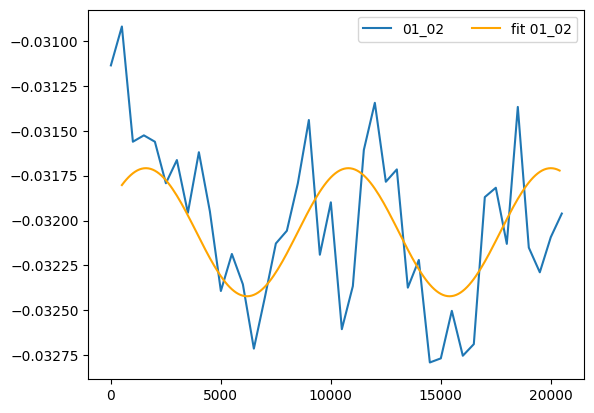

02 - fitted parameters: A=-0.03618801081934481, B=0.0006992629906252075, C=2.4053444659152157, D=0.0038115646380822163


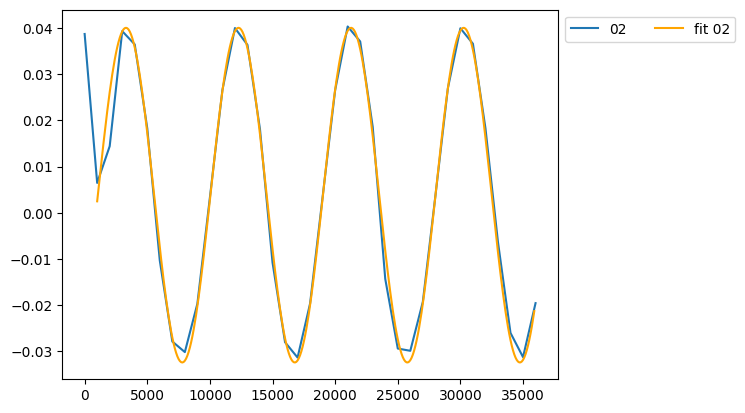

02_02 - fitted parameters: A=0.037831317261265124, B=0.0006991433913095518, C=0.7701875962928475, D=0.00700765678296687


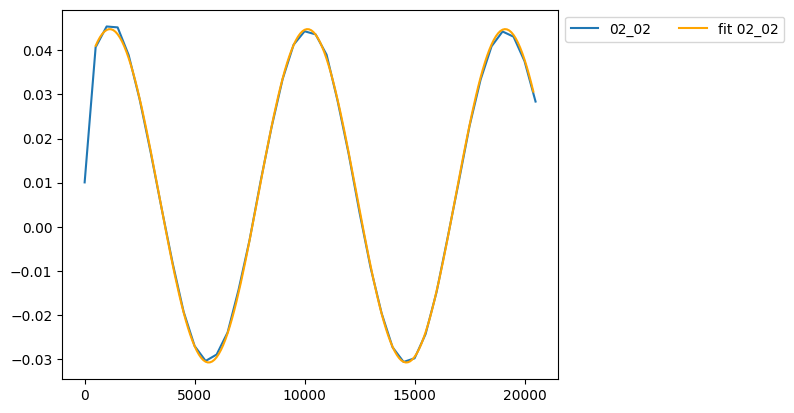

03 - fitted parameters: A=0.03827529750387149, B=0.0006973791968481134, C=0.7699232165589991, D=0.00828156993705134


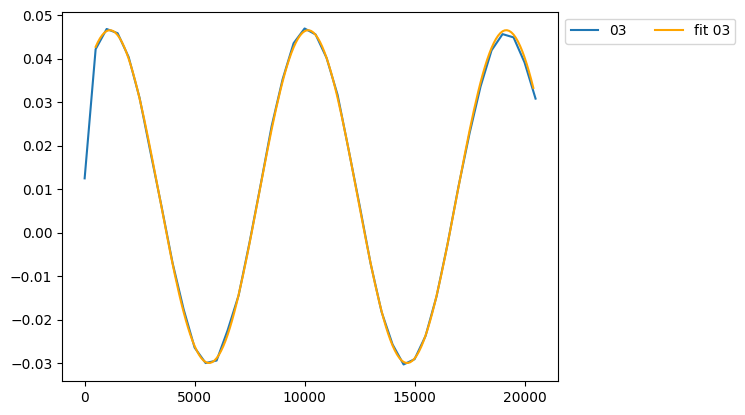

03_02 - fitted parameters: A=0.03804390988984928, B=0.000698359288448811, C=0.7757070904236262, D=0.005326567605560708


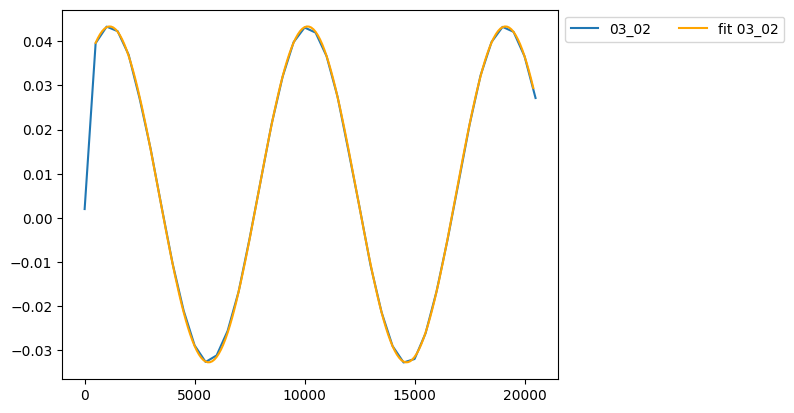

04 - fitted parameters: A=0.04325927531469917, B=0.0006997006388574206, C=0.829325484686443, D=0.027359201303952283


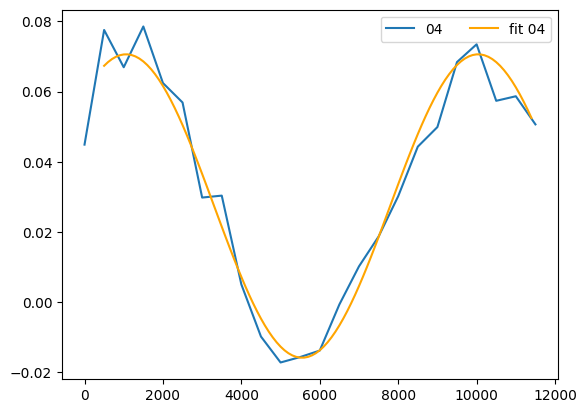

04_02 - fitted parameters: A=0.039743677989321505, B=0.000700760619531516, C=0.7707281380581081, D=0.011209220539799402


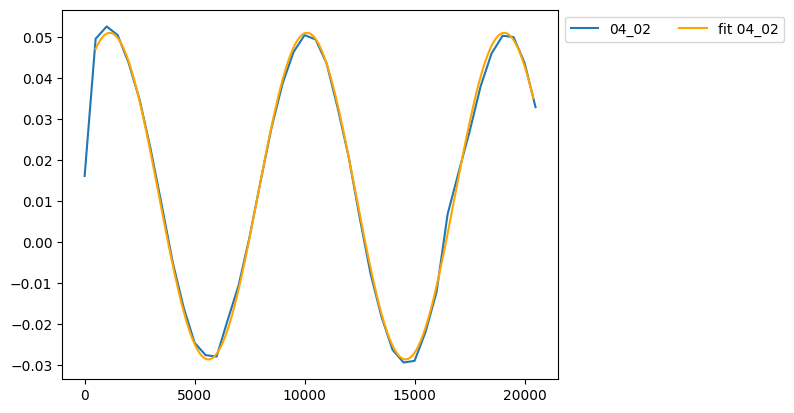

04_03 - fitted parameters: A=0.03928035184466624, B=0.0006978591612965668, C=0.7906782961771522, D=0.006940288594564959


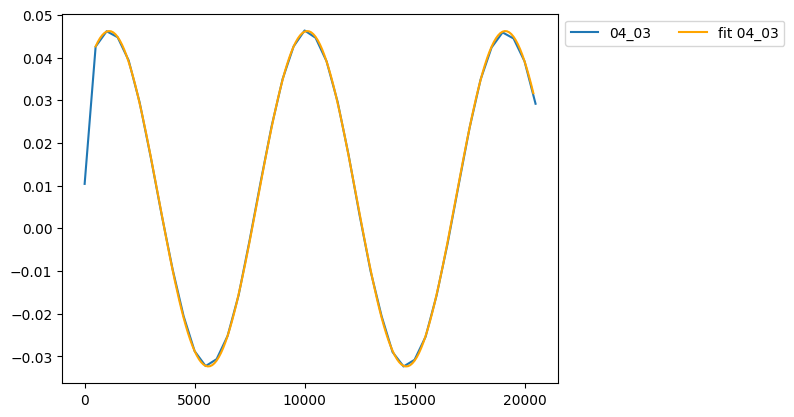

05_06_N48_blackmeasurement_nosleep - fitted parameters: A=0.05371892723684034, B=0.0006979637977887489, C=0.7813273885837181, D=0.020235676944434178


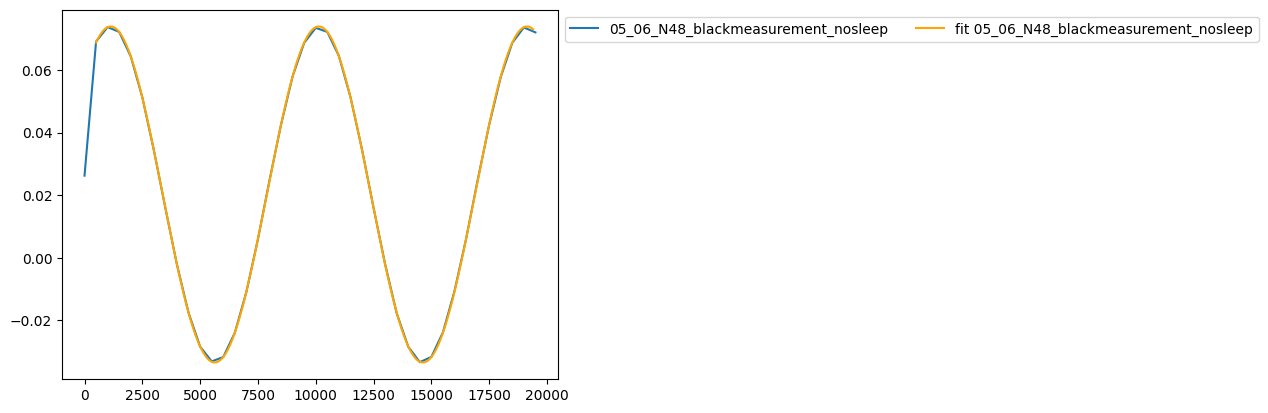

06 - fitted parameters: A=0.0706054316790939, B=0.0006981102036337647, C=0.778305840728361, D=0.03750592542126659


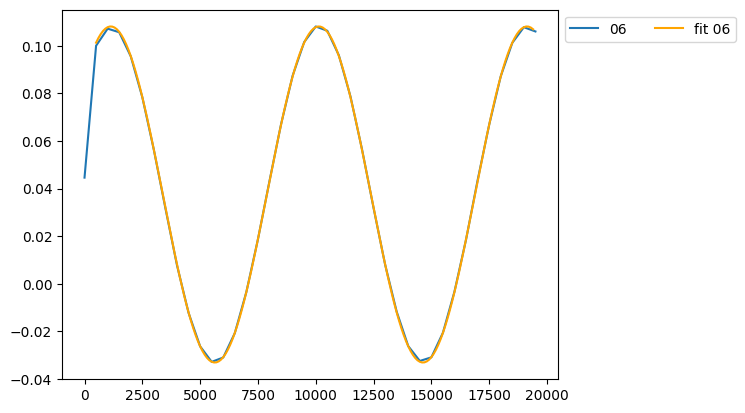

07 - fitted parameters: A=0.09212469282528613, B=0.0006980425308408753, C=0.7802838750634548, D=0.05910561446431206


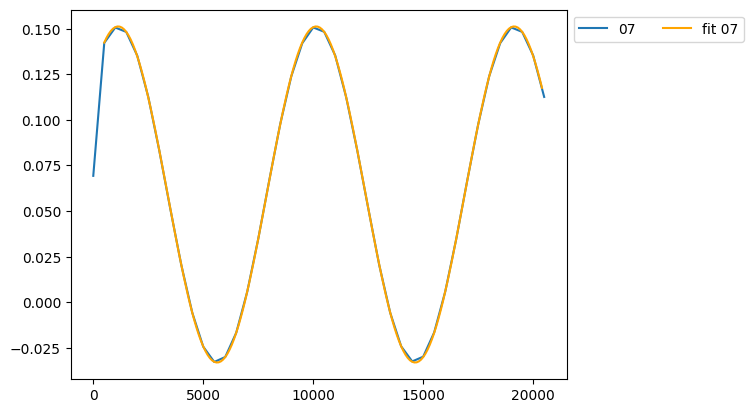

08 - fitted parameters: A=0.11810536873258366, B=0.0006981977003288577, C=0.7752550185311904, D=0.08540474074558409


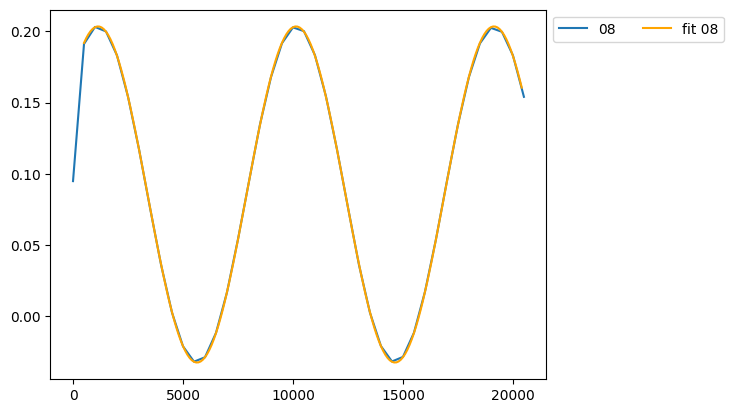

09 - fitted parameters: A=0.1498575844439466, B=0.0006980078373937582, C=0.7797386701107906, D=0.11733308877199693


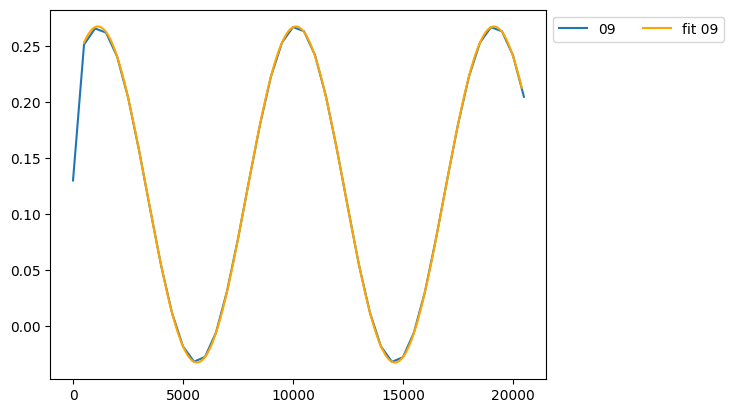

10 - fitted parameters: A=0.1960636595188981, B=0.0006884720165577492, C=0.8199937469409584, D=0.16242193222218065


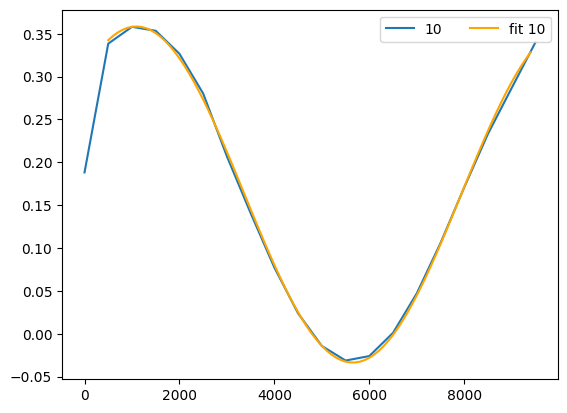

100 - fitted parameters: A=18.17220987642345, B=0.0006983572987462047, C=0.7707095515949626, D=18.402447739258406


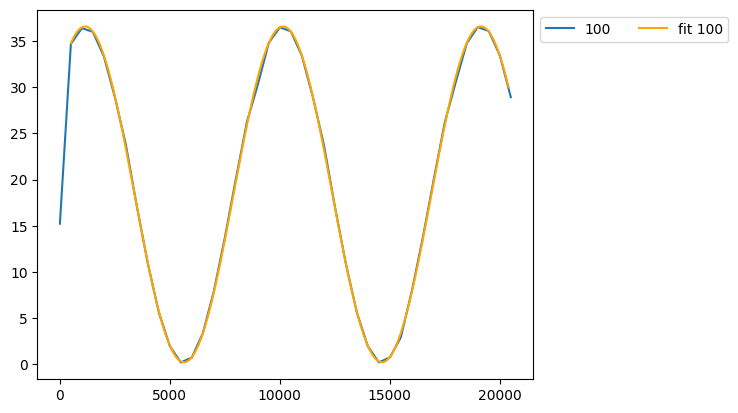

10_02 - fitted parameters: A=0.19600117234805442, B=0.000696251399777312, C=0.7878052688585567, D=0.1606344822778449


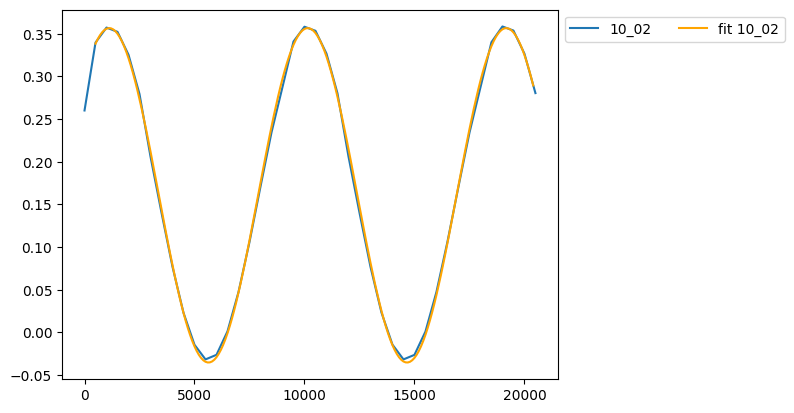

10_right - fitted parameters: A=0.19425270181713938, B=0.0006961982271141015, C=7.107315782866369, D=0.16040106737737556


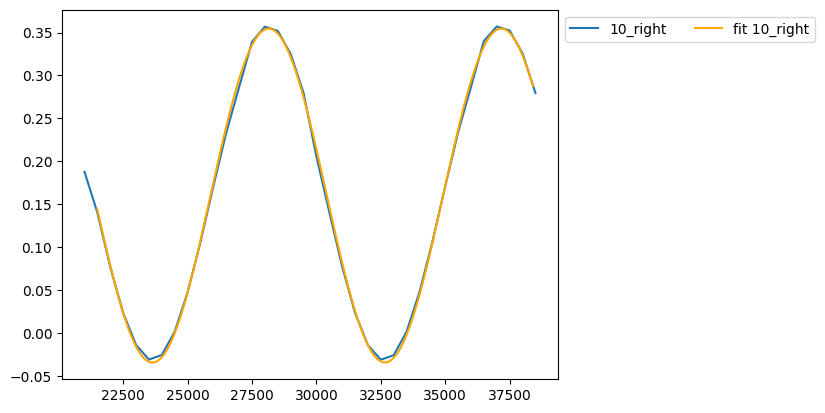

15 - fitted parameters: A=0.5107060388968993, B=0.0006985675367481983, C=0.7686131732991268, D=0.482362653867208


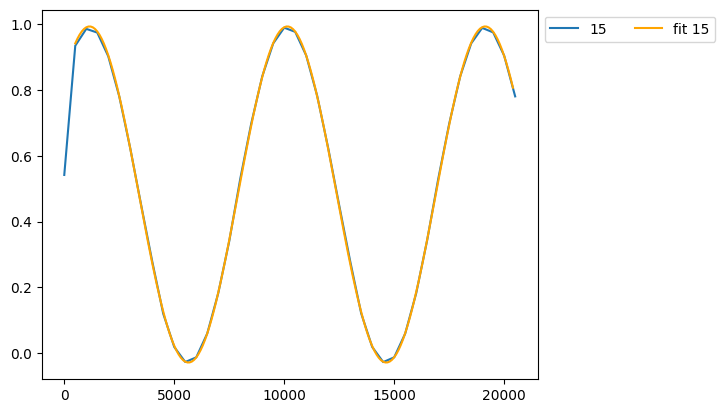

20 - fitted parameters: A=1.1217356344568699, B=0.0006983082994947185, C=0.7744295417864109, D=1.102134569080162


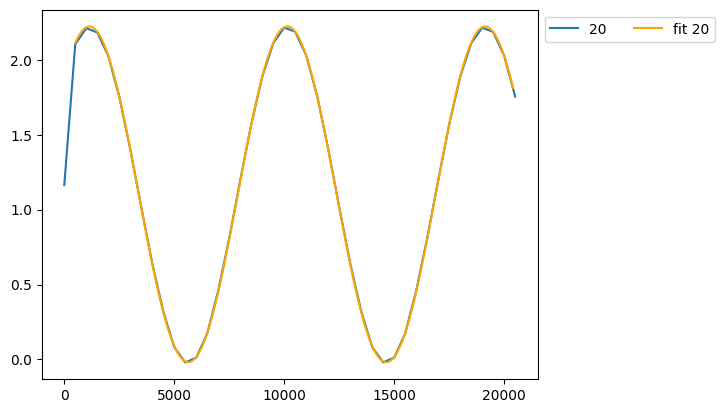

25 - fitted parameters: A=2.1114929854003583, B=0.0006983404969842004, C=0.7751081422779479, D=2.1014316941814886


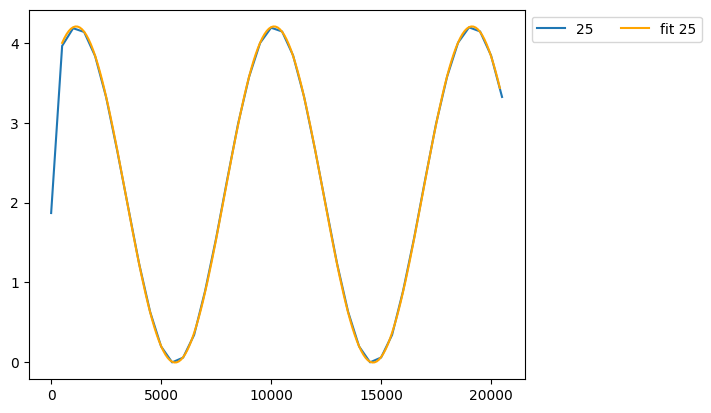

30 - fitted parameters: A=3.4817430684807578, B=0.0006982132164952087, C=0.7759121796670393, D=3.489802669486712


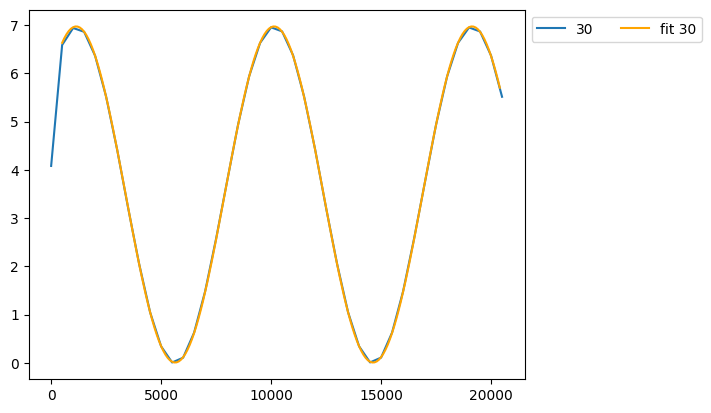

35 - fitted parameters: A=5.134427993265134, B=0.0006981761133635927, C=0.7763238350745744, D=5.156194164351514


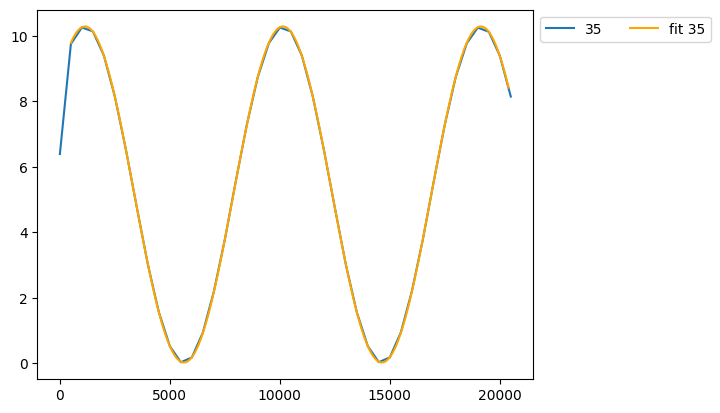

40 - fitted parameters: A=6.939872463296968, B=0.0006981788297290032, C=0.7762447272934923, D=6.986837391176248


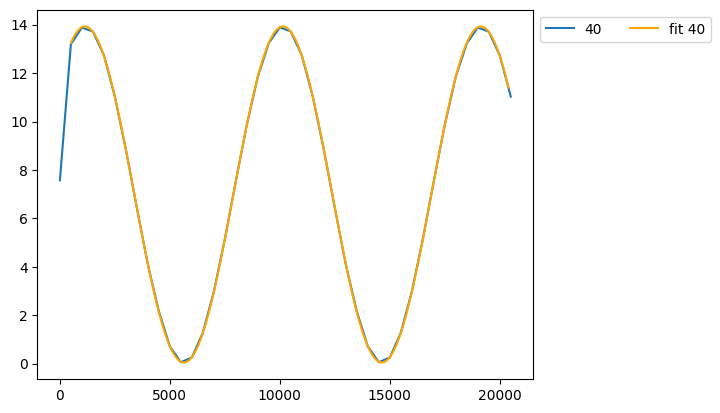

45 - fitted parameters: A=8.798815889909816, B=0.0006982799599342002, C=0.775031480879619, D=8.848437378951115


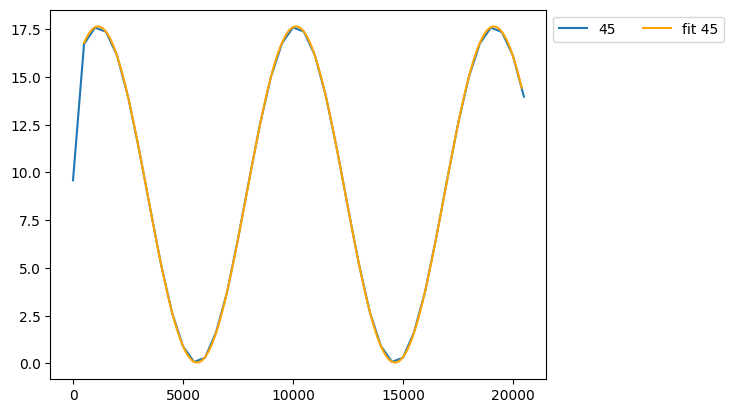

50 - fitted parameters: A=10.593700271246764, B=0.0006981979747690287, C=0.7757345966987531, D=10.674405631545708


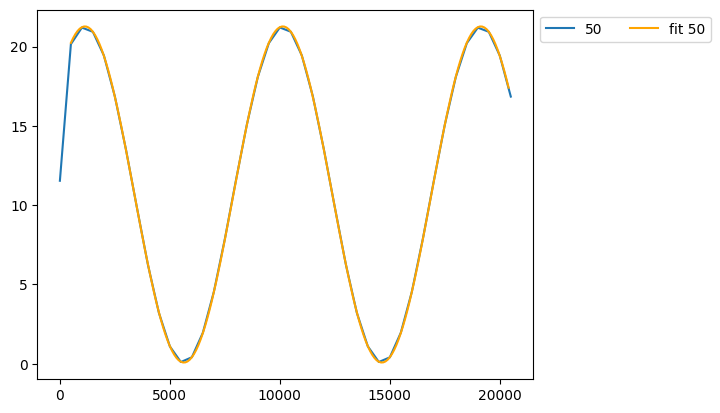

55 - fitted parameters: A=12.26887690054658, B=0.0006979551781997615, C=0.7796822967708814, D=12.375174134239622


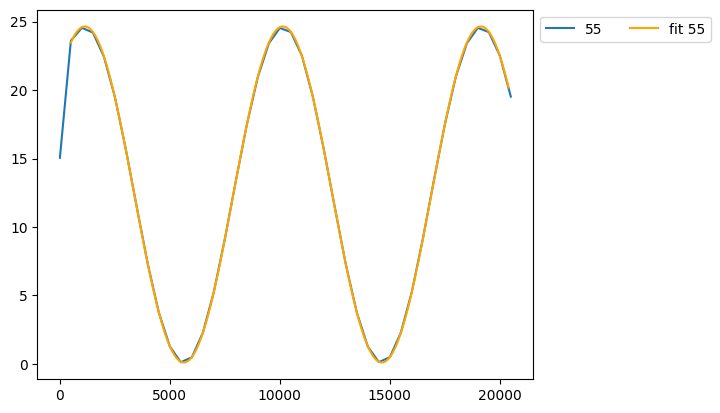

60 - fitted parameters: A=13.746444880756442, B=0.0006983144828505051, C=0.7749087530388019, D=13.870517604343217


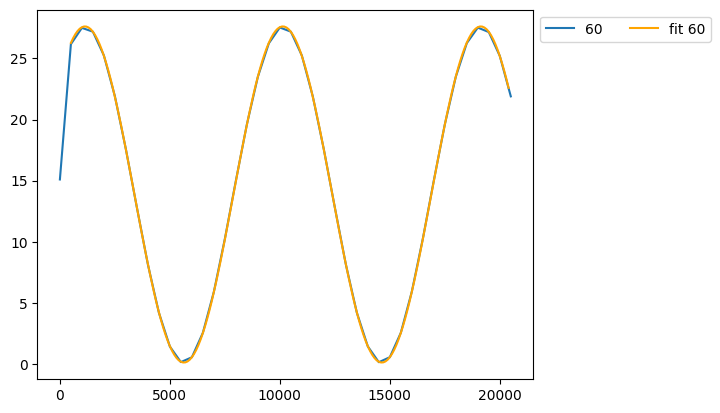

65 - fitted parameters: A=14.573549107772644, B=0.0006989484650860784, C=0.7624896969752625, D=14.944625129902349


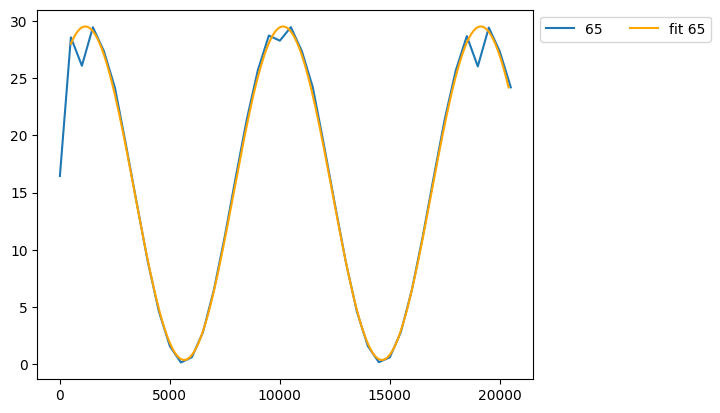

70 - fitted parameters: A=15.691159347075057, B=0.0007002217848439881, C=0.7487789346118027, D=15.965956160757418


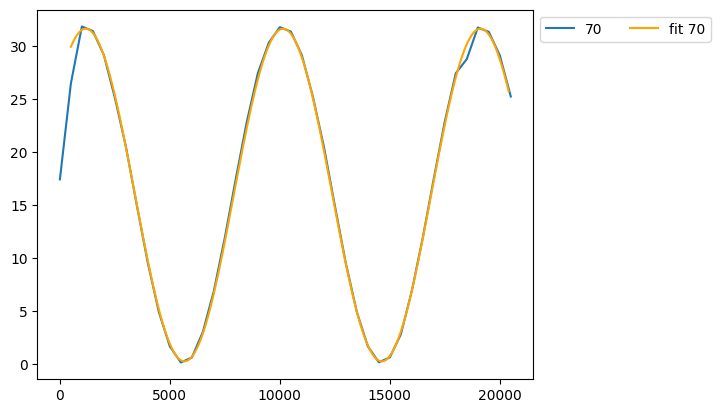

75 - fitted parameters: A=16.856761372966055, B=0.0006982600645638572, C=0.7773272344882654, D=17.001076943033322


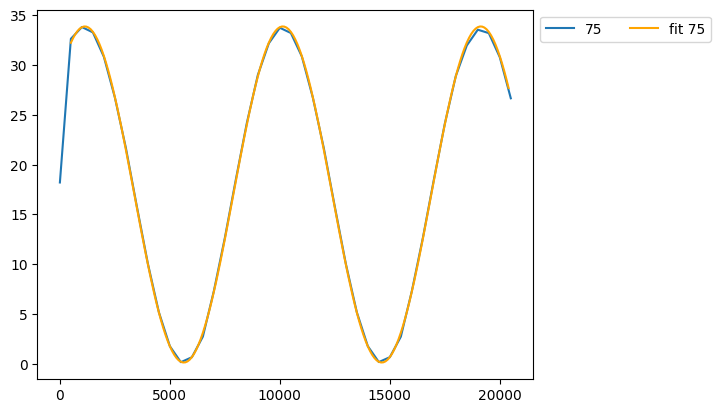

80 - fitted parameters: A=17.305645343374977, B=0.000697866644548474, C=0.7755314183263539, D=17.5173970173349


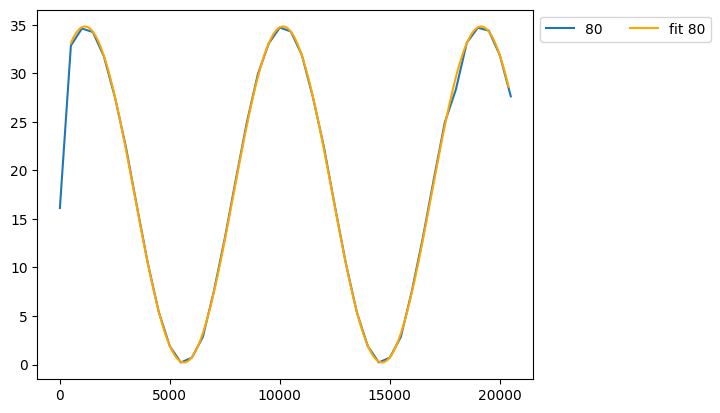

85 - fitted parameters: A=17.633107974281128, B=0.0006992397584107097, C=0.7534846366967248, D=17.85549087559871


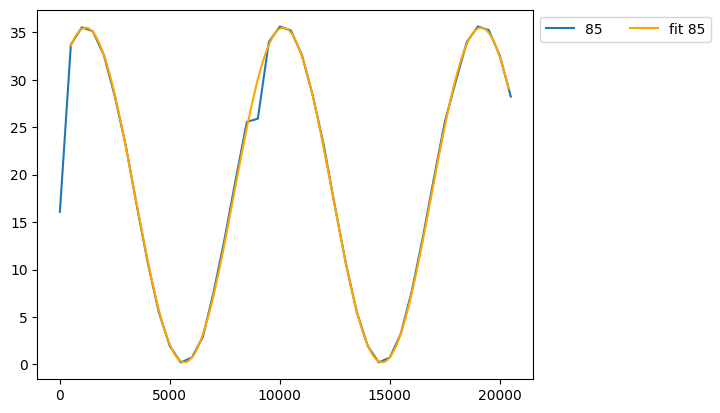

90 - fitted parameters: A=17.967443134710933, B=0.000698636098896899, C=0.7637641717121656, D=18.206957135800497


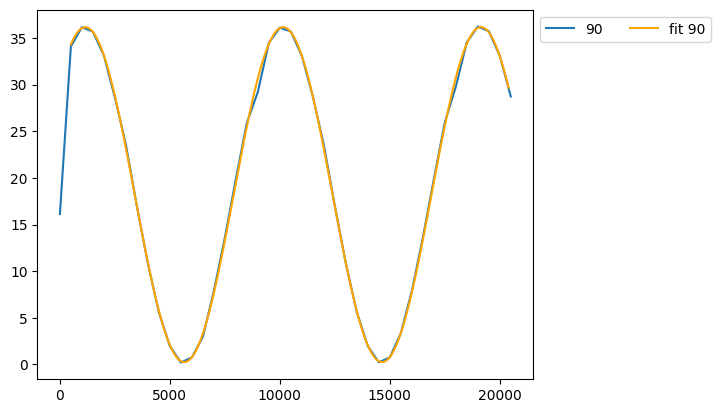

92 - fitted parameters: A=18.15940512565378, B=0.0006987232301884639, C=0.7675119178287264, D=18.35391749412806


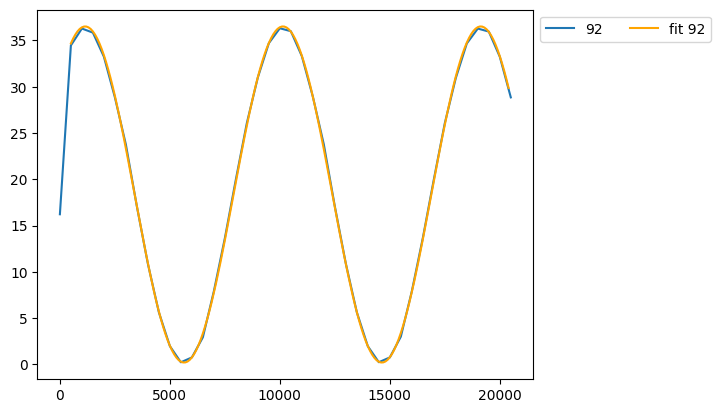

94 - fitted parameters: A=18.189886136953014, B=0.0006987677795494126, C=0.7677848694128581, D=18.36695698915042


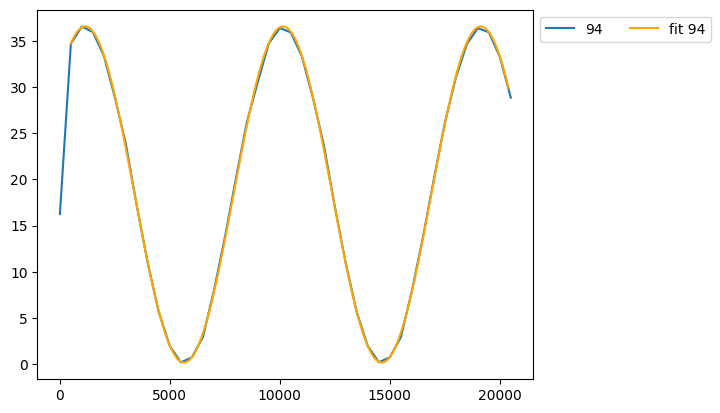

96 - fitted parameters: A=18.230117196084812, B=0.0006984204933080134, C=0.7693602078986685, D=18.428984710839256


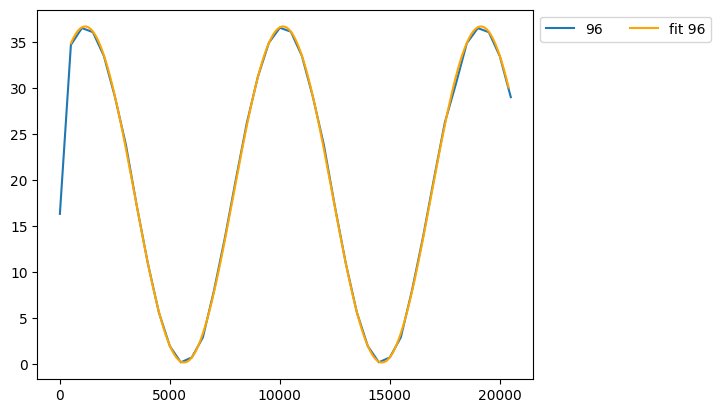

98 - fitted parameters: A=18.1709887797168, B=0.0006982724406999415, C=0.769225885218902, D=18.411403601878284


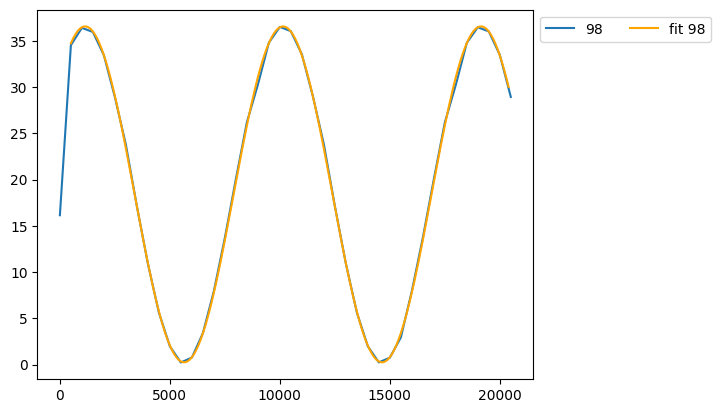

darkcount_20241022 - fitted parameters: A=-0.0007636192337979469, B=0.0014240322111432082, C=-2.633835242636419, D=-0.03101711925473176


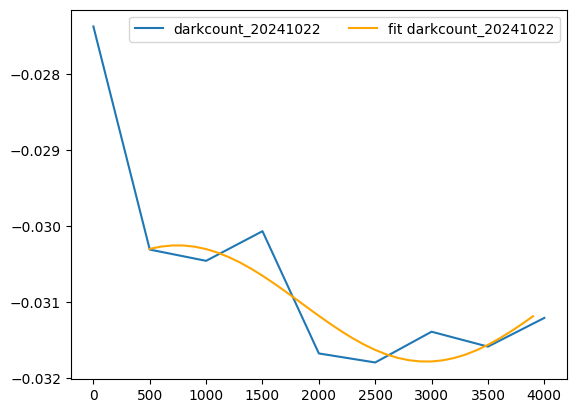

test_cooling2 - fitted parameters: A=-0.0010537584209740377, B=0.0006014103881790586, C=2.769489466238743, D=-0.025420170269191193


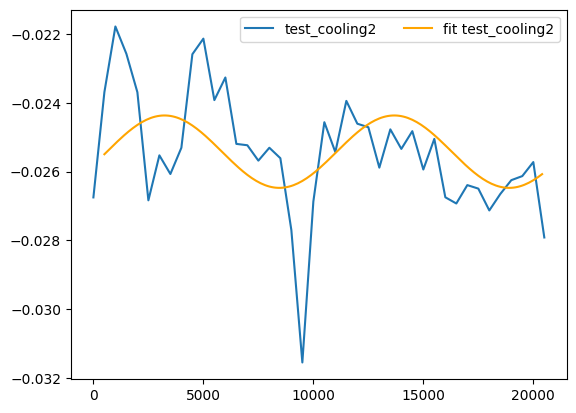

test_poweroff - fitted parameters: A=-0.002714242835114431, B=0.0005364086334381192, C=4.85640712976894, D=-0.01833192205291401


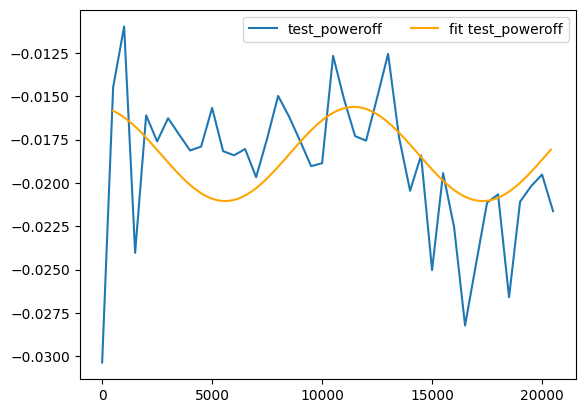

In [57]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Fits of Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')

for i, key in enumerate(after_hwp_select.keys()):
    # if i == current:
    data = after_hwp_select[key]
    steps = np.array(data['rotor_step'])
    vals = data['averaged']
    # error = np.array(data['stdev'])
    params, fitsteps, y_fit = fitter(steps, vals, p0_amp = max(vals), label=key)
    fit_params_results[i] = params
    plt.plot(steps, vals, label = key)
    plt.plot(fitsteps, y_fit, color = 'orange', label = f'fit {key}', alpha = 1)
    plt.legend(ncol =2 ,bbox_to_anchor = (1,1) )
    plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

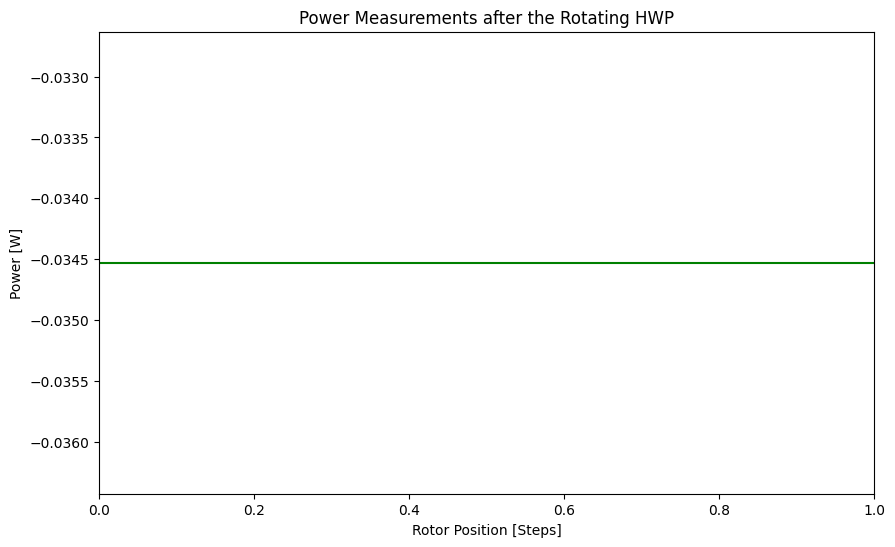

In [322]:
# plot all rfs tgt

fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')
#before hwp average

for i, data in enumerate(all_after):
   
    rf = os.path.basename(files_after_hwp[i+1]).split('rf')[1]
    # rf = os.path.basename(files_after_hwp[i+1]).split('rf')[1]
    if (not '100' in rf):
        rf = rf[0:2]
        label = f'rf{rf}'
    else:
        rf = rf[0:3]
        label = f'rf{rf}'

    # if 'N48' in os.path.basename(files_after_hwp[i+1]) or '03' in os.path.basename(files_after_hwp[i+1]):
    # if (rf == '15') or (rf=='10'):
    if i>=0 :
        print(i, label)
        print('hello ! | ')
        y = data['averaged']
        error = np.array(data['stdev'])

        # params, params_covariance = curve_fit(sine_function, x[3:], y[3:], p0 = [0.0361029908,0.0998, 3.87, 0.0046])
        # plt.plot(x, sine_function(x, *params), label='Fitted Sine Function', color='red')
        # print(i, "Fitted Parameters: A = {}, B = {}, C = {}, D = {}".format(*params))
        try:
            ax.axhline(before_hwp_avg[label], color = colors2[i], label = f'{label} before hwp')
        except KeyError:
            print(f'{label} isnt measured at before hwp')
        # ax.scatter(x, y, label=label, marker='x')
        # ax.plot(x, y, label=label, color = colors[i])
        ax.errorbar(x = x, y = y, yerr=error, fmt='-o', color = colors2[i], markersize = 0)
        # ax.errorbar(x = x, y = y, yerr=error, fmt='x', color = 'black', markersize = 1)
    ax.axvline(10000+100, color = 'black')
    
ax.legend(ncol = 2 ,bbox_to_anchor = (1,1))

In [ ]:
x = np.zeros(len(data['rotor_step']), dtype=float)

for j,step in enumerate(data['rotor_step']):
    lst = ast.literal_eval(step)
    array = np.array(lst, dtype=float)
    x[j] = array[0]

41 rfte
hello ! | 
rfte isnt measured at before hwp


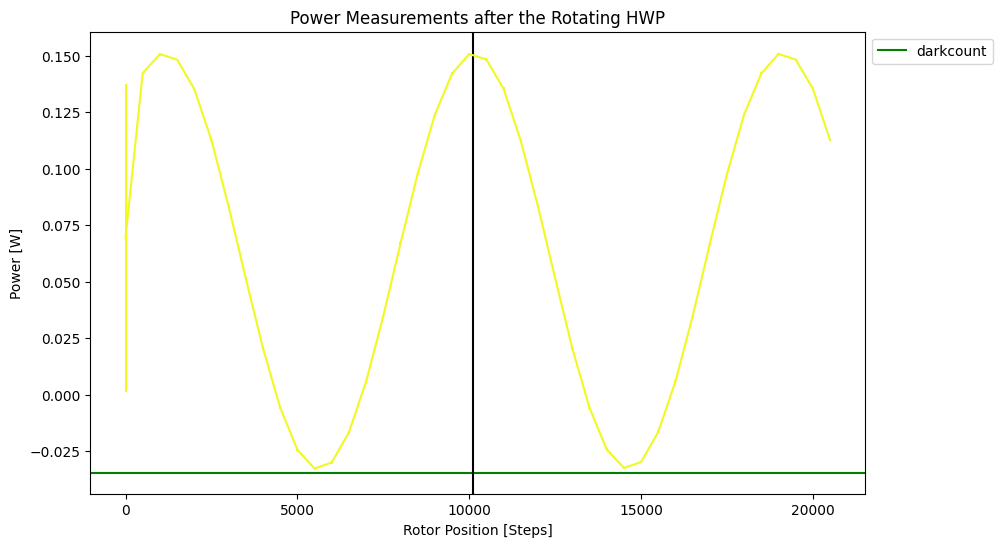

In [ ]:
fig, ax = plt.subplots(1,1, figsize =  (10,6))
ax.set_title('Power Measurements after the Rotating HWP')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Rotor Position [Steps]')

#darkcount line
ax.axhline(np.average(darkcounts['averaged']), color = 'green', label = 'darkcount')


rf = 12
data = all_after[rf]



rfname = os.path.basename(files_after_hwp[i+1]).split('rf')[1]

if (not '100' in rfname):
    rfname = rfname[0:2]
    label = f'rf{rfname}'
else:
    rfname = rfname[0:3]
    label = f'rf{rfname}'

print(i, label)
print('hello ! | ')
y = data['averaged']
error = np.array(data['stdev'])

# params, params_covariance = curve_fit(sine_function, x[3:], y[3:], p0 = [0.0361029908,0.0998, 3.87, 0.0046])
# plt.plot(x, sine_function(x, *params), label='Fitted Sine Function', color='red')
# print(i, "Fitted Parameters: A = {}, B = {}, C = {}, D = {}".format(*params))
try:
    ax.axhline(before_hwp_avg[label], color = colors2[i], label = f'{label} before hwp')
except KeyError:
    print(f'{label} isnt measured at before hwp')
# ax.scatter(x, y, label=label, marker='x')
# ax.plot(x, y, label=label, color = colors[i])
ax.errorbar(x = x, y = y, yerr=error, fmt='-o', color = colors2[i], markersize = 0)
# ax.errorbar(x = x, y = y, yerr=error, fmt='x', color = 'black', markersize = 1)
ax.axvline(10000+100, color = 'black')
    
ax.legend(ncol = 2 ,bbox_to_anchor = (1,1))